## Presentation Plots

Make plots for poster, paper, presentation

In [1]:
import h5py as h5
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import median_filter
import seaborn as sns
import csv
from plasma_tv.utils.helpers import *
from plasma_tv.data.file_utils import GetEmission

sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.linewidth'] = "1.5"
plt.rcParams['font.weight'] = "bold"

In [2]:
data_path = '/scratch/gpfs/nc1514/plasma_tv/data/external/toksearch/aps_sig.h5'
irtv_path = '../data/external/toksearch/irtv_12_03_2024.pkl'

In [3]:
data = h5.File(data_path, 'r')

In [4]:
from scipy.io import readsav
from matplotlib.colors import Normalize

In [5]:
prad_path = Path('/scratch/gpfs/nc1514/plasma_tv/data/external/TangTV/image201081.02700')
prad_dat = readsav(prad_path)
prad_image = prad_dat['prad_image']
prad_rarr = prad_dat['prad_rarr']
prad_zarr = prad_dat['prad_zarr']

tv_path = Path('/scratch/gpfs/nc1514/plasma_tv/data/external/TangTV')
tv = GetEmission(tv_path)
files = tv.list_files(True)
file_idx = 1
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])

0 	 200977
1 	 201081
Extracting sav for shot: 201081
Resizing...


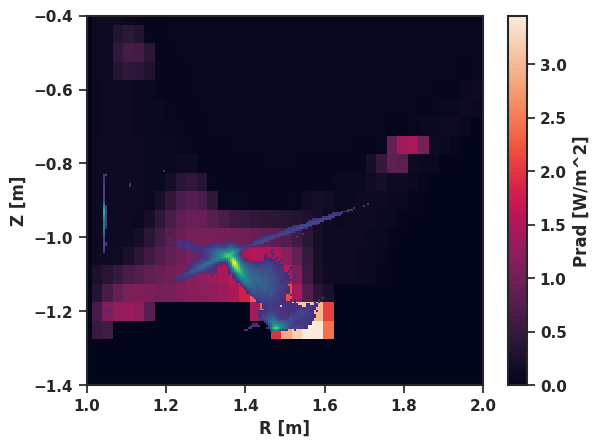

In [6]:
thresh = 0.25
inverted_filter = inverted[42] * (inverted[42] > thresh)
alpha = Normalize(vmin=np.min(inverted_filter), vmax=np.max(inverted_filter))(inverted_filter) * 500
alpha[alpha > 1] = 1
fig, ax = plt.subplots()
pcm1 = ax.pcolormesh(prad_rarr, prad_zarr, prad_image)
pcm2 = ax.pcolormesh(radii[42], elevation[42], inverted_filter, cmap = 'viridis')
pcm2.set_alpha(alpha)
pcm1.colorbar = fig.colorbar(pcm1, ax=ax, label='Prad [W/m^2]')

plt.xlim(1,2)
plt.ylim(-1.4,-0.4)
plt.xlabel('R [m]')
plt.ylabel('Z [m]')

plt.savefig('../output/paper/pradciii.png', dpi=300)
plt.show()

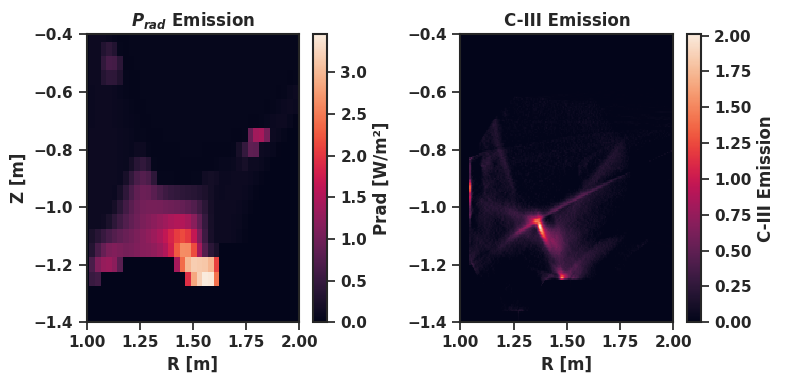

In [7]:
# Create a figure with 3 subplots (side-by-side):
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# ------------------------------
# First subplot: pcm1
# ------------------------------
pcm1 = ax1.pcolormesh(prad_rarr, prad_zarr, prad_image, shading='auto')
fig.colorbar(pcm1, ax=ax1, label='Prad [W/m²]')
ax1.set_xlim(1, 2)
ax1.set_ylim(-1.4, -0.4)
ax1.set_xlabel('R [m]')
ax1.set_ylabel('Z [m]')
ax1.set_title('$P_{rad}$ Emission', fontweight='bold')

# ------------------------------
# Second subplot: pcm2
# ------------------------------
ciii = inverted[42].copy()
ciii[ciii == 0] = inverted[42].min()
pcm2 = ax2.pcolormesh(radii[42], elevation[42], ciii, shading='auto')
# pcm2.set_alpha(alpha)
fig.colorbar(pcm2, ax=ax2, label='C-III Emission')
ax2.set_xlim(1, 2)
ax2.set_ylim(-1.4, -0.4)
ax2.set_xlabel('R [m]')
ax2.set_title('C-III Emission', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/paper/pradciii.png', dpi=300)
plt.show()

## 201076

26


<Figure size 640x480 with 0 Axes>

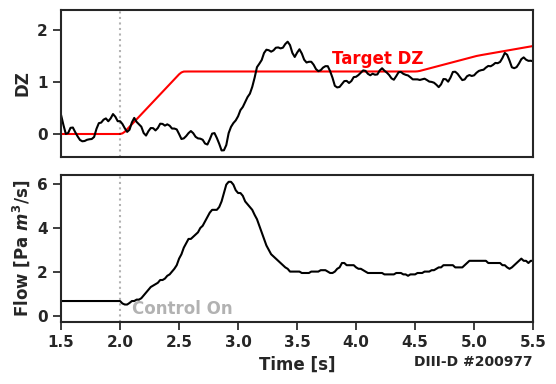

In [8]:
with open('../data/external/gasvalve/199626.csv', mode='r') as infile:
    reader = csv.reader(infile, delimiter='	')
    gasvalve = [[float(rows[0]),float(rows[1])] for rows in reader]
gasvalve = np.array(gasvalve).T
gasvalve_voltage = np.arange(0,10,0.01)
gasvalve_flow = np.interp(gasvalve_voltage, gasvalve[0], gasvalve[1])
gasvalve_dict = dict(zip(gasvalve_voltage, gasvalve_flow))

shot = 200977
thomson_dat = []
shot_str = str(shot)
for i in range(1,5):
    thomson_dat.append(data[shot_str][f'tssdivte0{str(i)}'][:])
thomson_dat = np.array(thomson_dat)
gas_dat = data[shot_str]['gasA'][:] / 100
lfsdz_dat = data[shot_str]['lfsdz'][:]
lftdz_dat = data[shot_str]['lftdz'][:]
x_pt = data[shot_str]['RXPT1_EFIT01'][:]
times = data['times'][:] / 1000
coords = data['spatial_coordinates'][:]
median_filtered_thomson_dat = np.array([median_filter(thomson_dat[i], size=3) for i in range(4)])

detach = 2.850
attach = 4.420
detachp100 = detach + 100
attachp100 = attach + 100
xlim = (1.500, 5.500)

# Create figure and GridSpec layout
plt.clf()
fig = plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[50, 1], height_ratios=[1, 1])

# First subplot (row 0, column 0)
ax1ylim = (0, 1.8)
ax1 = plt.subplot(gs[0, 0])
ax1.plot(times, 1 - lftdz_dat, c='red', label='lftDZ')
ax1.plot(times, 1 - lfsdz_dat, c='black', label='lfsDZ')
ax1.axvline(2.000, color='black', alpha=0.3, linestyle='dotted')
ax1.set_xlim(xlim[0], xlim[1])
ax1.set_xticks([])
ax1.set_ylabel('DZ')
ax1.annotate('Target DZ', xy=(3.8, 1.35), xytext=(3.8, 1.35), c='red', fontsize=12)

# Second subplot (row 1, column 0)
ax2 = plt.subplot(gs[1, 0])
print(nearest_index(gasvalve_voltage,gas_dat[0]))
gas_flow = [gasvalve_flow[nearest_index(gasvalve_voltage,val)] for val in gas_dat]
# ax2.plot(times, gas_dat, c='black')
ax2.plot(times, gas_flow, c='black')
ax2.axvline(2.000, color='black', alpha=0.3, linestyle='dotted')
ax2.set_xlim(xlim[0], xlim[1])
# ax2.set_ylabel('Command [V]')
ax2.set_ylabel('Flow [Pa $m^3$/s]')
ax2.set_xlim(xlim[0], xlim[1])
ax2.set_xticks(np.arange(xlim[0], xlim[1]+.500, .500))
ax2.set_xlabel('Time [s]')
ax2.annotate('Control On', xy=(2.1, 0.05), xytext=(2.1, 0.05), c='black', alpha=0.3, fontsize=12)

plt.annotate(f'DIII-D #{shot}', xy=(1, -0.3), xycoords='axes fraction', ha='right', fontsize=10)

# Set the overall title and adjust layout
# fig.suptitle('Control of shot ' + shot_str + ' with Model 1')
plt.tight_layout()
plt.savefig('../output/paper/200977.png', dpi=300)
plt.show()

## 201081

In [9]:
ir_shot = 9 # 9 for 201081
irtv_shots = range(201072,201086)
print(irtv_shots[ir_shot])
irtv = pickle.load(open(irtv_path, 'rb'))
irtv_data = irtv[ir_shot]
shot, x_ir, t_ir, pos_ir, units_ir = irtv_data
x_ir /= 100
pos_ir /= 100
t_ir /= 1000

201081


In [10]:
t_ir_edges = np.concatenate(([t_ir[0] - (t_ir[1] - t_ir[0]) / 2], 
                                  (t_ir[:-1] + t_ir[1:]) / 2, 
                                  [t_ir[-1] + (t_ir[-1] - t_ir[-2]) / 2]))

pos_ir_edges = np.concatenate(([pos_ir[0] - (pos_ir[1] - pos_ir[0]) / 2], 
                               (pos_ir[:-1] + pos_ir[1:]) / 2, 
                               [pos_ir[-1] + (pos_ir[-1] - pos_ir[-2]) / 2]))

# Use the calculated edges in pcolormesh
# plt.pcolormesh(t_ir_edges, pos_ir_edges, x_ir.T, cmap='inferno')
# plt.colorbar()
# plt.show()

<Figure size 640x480 with 0 Axes>

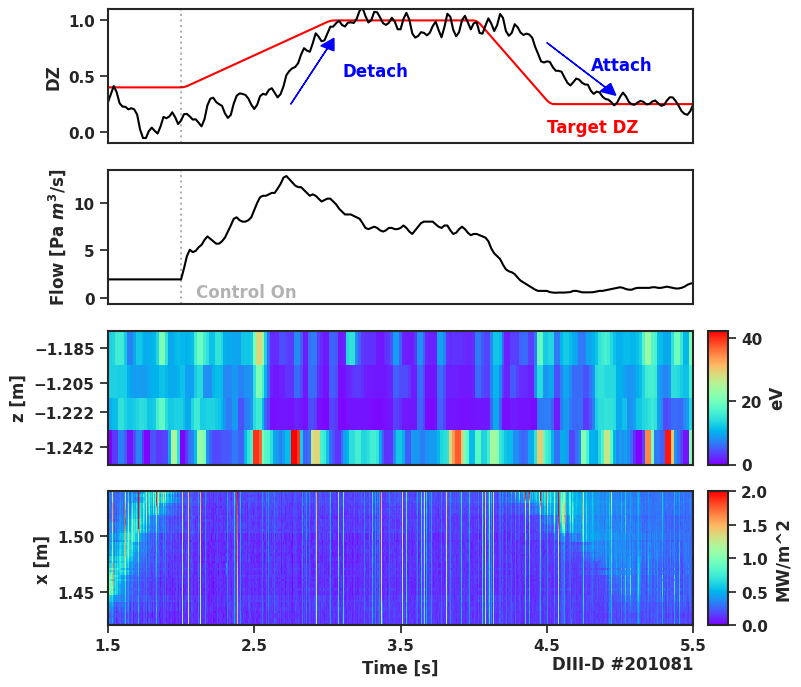

In [14]:
shot = 201081
thomson_dat = []
shot_str = str(shot)
# thomson_dat.append(data[shot_str]["tssdivte00'"][:])
for i in range(1,5):
    thomson_dat.append(data[shot_str][f'tssdivte0{str(i)}'][:])
thomson_dat = np.array(thomson_dat)
gas_dat = data[shot_str]['gasA'][:] / 100
lfsdz_dat = data[shot_str]['lfsdz'][:]
lftdz_dat = data[shot_str]['lftdz'][:]
x_pt = data[shot_str]['RXPT1_EFIT01'][:]
times = data['times'][:] / 1000
coords = data['spatial_coordinates'][:]
median_filtered_thomson_dat = np.array([median_filter(thomson_dat[i], size=3) for i in range(4)])
xlim = (1.500, 5.500)

# Create figure and GridSpec layout
plt.clf()
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 2, width_ratios=[30, 1], height_ratios=[1, 1, 1, 1])

# First subplot (row 0, column 0)
ax1ylim = (-0.1, 1.1)
ax1 = plt.subplot(gs[0, 0])
ax1.plot(times, 1 - lftdz_dat*3, c='red')
ax1.plot(times, 1 - lfsdz_dat*3, c='black')
ax1.axvline(2.000, color='black', alpha=0.3, linestyle='dotted')
ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ax1ylim[0], ax1ylim[1])
ax1.set_xticks([])
ax1.set_ylabel('DZ')
ax1.annotate('Target DZ', xy=(4.5, 0), xytext=(4.5, 0), c='red', fontsize=12)
ax1.annotate('Detach', xy=(1.75, 0.7), xytext=(3.1, 0.5), c='blue', fontsize=12)
ax1.annotate('Attach', xy=(3.1, 0.6), xytext=(4.8, 0.55), c='blue', fontsize=12)
ax1.arrow(2.75, 0.25, 0.25, 0.5, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
ax1.arrow(4.5, 0.8, 0.4, -0.4, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

# Second subplot (row 1, column 0)
ax2ylim = (0, 1.35)
ax2 = plt.subplot(gs[1, 0])
gas_flow = [gasvalve_flow[nearest_index(gasvalve_voltage,val)] for val in gas_dat]
# ax2.plot(times, gas_dat, c='black')
ax2.plot(times, gas_flow, c='black')
ax2.axvline(2.000, color='black', alpha=0.3, linestyle='dotted')
ax2.annotate('Control On', xy=(2.1, 0.05), xytext=(2.1, 0.05), c='black', alpha=0.3, fontsize=12)
ax2.set_xlim(xlim[0], xlim[1])
# ax2.set_ylim(ax2ylim[0], ax2ylim[1])
ax2.set_xticks([])
# ax2.set_ylabel('Command [V]')
ax2.set_ylabel('Flow [Pa $m^3$/s]')

# # Third subplot (row 2, column 0)
# Your data and times should already be defined.
depths = np.array([-1.242, -1.222, -1.205, -1.185])

ax3 = plt.subplot(gs[2, 0])
# Use shading='auto' so that the provided y coordinates are interpreted as cell centers.
cax = ax3.pcolormesh(times, depths, median_filtered_thomson_dat, cmap='rainbow', shading='auto')
ax3.set_yticks(depths)  # This will place ticks exactly at the depth centers.
ax3.set_xlim(xlim[0], xlim[1])
ax3.set_xticks([])
ax3.set_ylabel('z [m]')

# # Fourth subplot (row 0-2, column 1)
ax4 = plt.subplot(gs[3, 0])
ccax = ax4.pcolormesh(t_ir_edges, pos_ir_edges, x_ir.T,vmin=0,vmax=2, cmap='rainbow')
ax4.set_ylim(1.42,1.54)
ax4.set_xlim(xlim[0],xlim[1])
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('x [m]')
ax4.set_xticks(np.arange(xlim[0], xlim[1]+.500, 1.000))

# # Colorbar (row 0-2, column 1)
cbar_ax2 = plt.subplot(gs[2, 1])  # Use the same row as ax3 (row 2)
fig.colorbar(cax, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('eV')

# # Colorbar (row 0-2, column 1)
cbar_ax3 = plt.subplot(gs[3, 1])  # Use the same row as ax3 (row 2)
fig.colorbar(ccax, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('MW/m^2')

# Set the overall title and adjust layout
# fig.suptitle('Control of shot ' + shot_str + ' with Model 2')
ax4.annotate(f'DIII-D #{shot}', xy=(1, -0.33), xycoords='axes fraction', ha='right', fontsize=12)
gs.update(wspace=0.05)
plt.savefig('../output/paper/201081.png', dpi=300)
plt.show()

In [17]:
np.where(times==3)

(array([75]),)

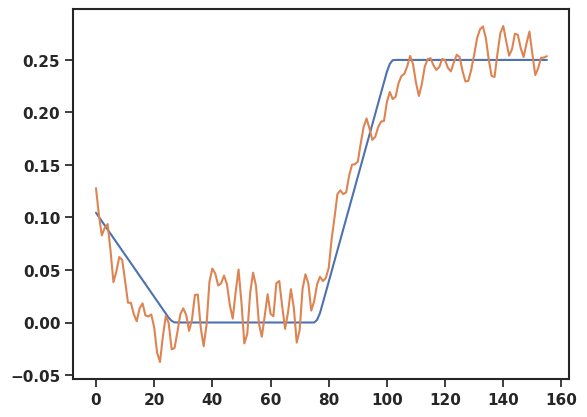

In [38]:
shift = -15
plt.plot(lftdz_dat[50:-19])
plt.plot(np.roll(lfsdz_dat, shift)[50:-19])
plt.show()

In [39]:
mae = np.mean(np.abs(np.roll(lfsdz_dat, shift)[50:-19] - lftdz_dat[50:-19]))
print(mae)

0.020418171317867696


In [41]:
mae = np.mean(np.abs(lfsdz_dat - lftdz_dat))
print(mae)

0.05870769762699881


(34999, 396)
(34999, 250)
0


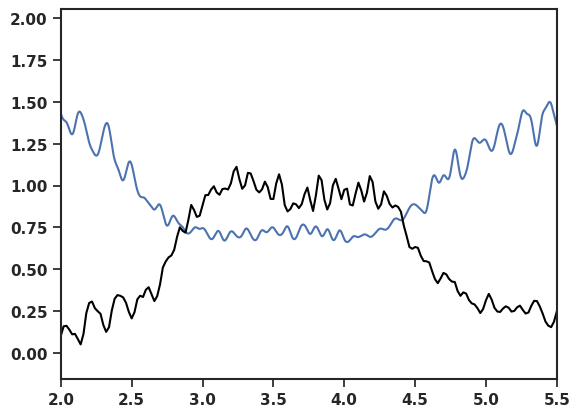

In [12]:
# plt.pcolormesh(t_ir_edges, pos_ir_edges, x_ir.T,vmin=0,vmax=2, cmap='rainbow')
print(x_ir.shape)
x_ir_crop = x_ir[:,75:325]
print(x_ir_crop.shape)
int_x_ir = np.sum(x_ir, axis=1)
spikes = np.where(x_ir_crop > 50)[0]
spikes_times = t_ir[spikes]
print(len(spikes))
lowpass = gaussian_filter1d(int_x_ir, 100)
plt.plot(t_ir, lowpass/100)
plt.plot(times, 1 - lfsdz_dat*3, c='black')
plt.vlines(spikes_times, 0, 1, color='red', alpha=0.5)
plt.xlim(2, xlim[1])
plt.show()

201085


<Figure size 640x480 with 0 Axes>

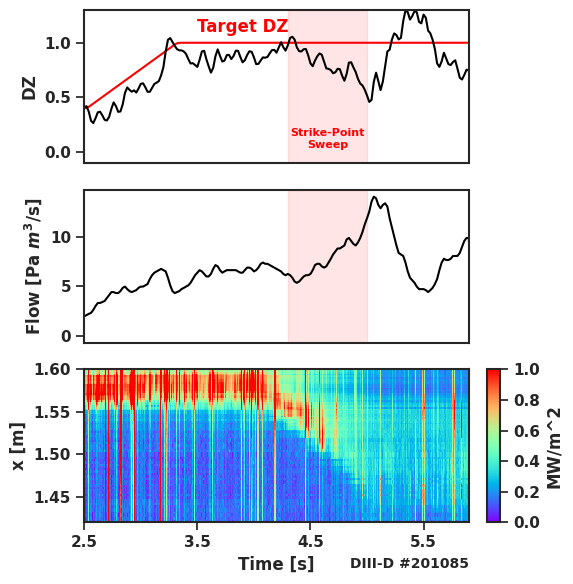

In [13]:
irtv_shots = range(201072,201086)
ir_shot = 13
irtv = pickle.load(open(irtv_path, 'rb'))
irtv_data = irtv[ir_shot]
shot, x_ir, t_ir, pos_ir, units_ir = irtv_data
x_ir /= 100
pos_ir /= 100
t_ir /= 1000

t_ir_edges = np.concatenate(([t_ir[0] - (t_ir[1] - t_ir[0]) / 2], 
                                  (t_ir[:-1] + t_ir[1:]) / 2, 
                                  [t_ir[-1] + (t_ir[-1] - t_ir[-2]) / 2]))

pos_ir_edges = np.concatenate(([pos_ir[0] - (pos_ir[1] - pos_ir[0]) / 2], 
                               (pos_ir[:-1] + pos_ir[1:]) / 2, 
                               [pos_ir[-1] + (pos_ir[-1] - pos_ir[-2]) / 2]))

irtv_shots = np.concatenate([range(2200970,200978),range(201072,201085)])
print(shot)

shot = 201085
thomson_dat = []
shot_str = str(shot)
# thomson_dat.append(data[shot_str]["tssdivte00'"][:])
for i in range(1,5):
    thomson_dat.append(data[shot_str][f'tssdivte0{str(i)}'][:])
thomson_dat = np.array(thomson_dat)
gas_dat = data[shot_str]['gasA'][:] / 100
lfsdz_dat = data[shot_str]['lfsdz'][:]
lftdz_dat = data[shot_str]['lftdz'][:]
x_pt = data[shot_str]['RXPT1_EFIT01'][:]
times = data['times'][:] / 1000
coords = data['spatial_coordinates'][:]
median_filtered_thomson_dat = np.array([median_filter(thomson_dat[i], size=3) for i in range(4)])

detach = 2675
attach = 4575
xlim = (2.500, 5.900)
xlim[0], xlim[1]

# Create figure and GridSpec layout
plt.clf()
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(3, 2, width_ratios=[30, 1], height_ratios=[1, 1, 1])

# First subplot (row 0, column 0)
ax1ylim = (-0.1, 1.3)
ax1 = plt.subplot(gs[0, 0])
ax1.plot(times, 1 - lftdz_dat*3, c='red', label='lftDZ (x3)')
ax1.plot(times, 1 - lfsdz_dat*3, c='black', label='lfsDZ (x3)')
ax1.axvspan(4.3, 5.0, color='red', alpha=0.1)
# ax1.hlines(1, xlim[0], xlim[1], colors='C7', linestyle='dotted')
ax1.annotate('Target DZ', xy=(4.5, 0), xytext=(3.5, 1.1), c='red', fontsize=12)
ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ax1ylim[0], ax1ylim[1])
ax1.set_xticks([])
ax1.set_ylabel('DZ')
ax1.annotate(f'Strike-Point\nSweep', xy=(0.633,0.1), xycoords='axes fraction', ha='center', fontsize=8, color = 'red')
# ax1.legend()

# Second subplot (row 1, column 0)
ax2ylim = (.25, 1.50)
ax2 = plt.subplot(gs[1, 0])
gas_flow = [gasvalve_flow[nearest_index(gasvalve_voltage,val)] for val in gas_dat]
# ax2.plot(times, gas_dat, c='black')
ax2.plot(times, gas_flow, c='black')
ax2.axvspan(4.3, 5.0, color='red', alpha=0.1)
ax2.set_xlim(xlim[0], xlim[1])
# ax2.set_ylim(ax2ylim[0], ax2ylim[1])
ax2.set_xticks([])
# ax2.set_ylabel('Command [V]')
ax2.set_ylabel('Flow [Pa $m^3$/s]')

# # Fourth subplot (row 0-2, column 1)
ax4 = plt.subplot(gs[2, 0])
ccax = ax4.pcolormesh(t_ir_edges, pos_ir_edges, np.transpose(x_ir),vmin=0,vmax=1,cmap='rainbow')
ax4.set_ylim(1.42,1.6)
ax4.set_xlim(xlim[0],xlim[1])
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('x [m]')
ax4.set_xticks(np.arange(xlim[0], xlim[1]+.500, 1.000))
ax4.annotate(f'DIII-D #{shot}', xy=(1, -0.3), xycoords='axes fraction', ha='right', fontsize=10)

# # Colorbar (row 0-2, column 1)
cbar_ax = plt.subplot(gs[2, 1])  # Use the same row as ax3 (row 2)
fig.colorbar(ccax, cax=cbar_ax, orientation='vertical')
cbar_ax.set_ylabel('MW/m^2')

# Set the overall title and adjust layout
# fig.suptitle('Control of shot ' + shot_str + ' with Model 2')
plt.tight_layout()
plt.savefig('../output/paper/201085.png', dpi=300)
plt.show()

## Inversion

In [95]:
import numpy as np
from plasma_tv.data.file_utils import GetEmission
from scipy.io import readsav
from pathlib import Path

file_idx = 8
tv = GetEmission(Path('../data/raw/all'))
files = tv.list_files()
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])

Number of files: 26
Extracting sav for shot: 189097


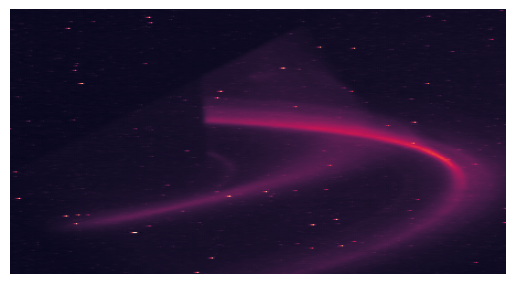

In [96]:
plt.imshow(np.flip(vid[150],axis=1)[:,:450])
plt.axis('off')
plt.show()

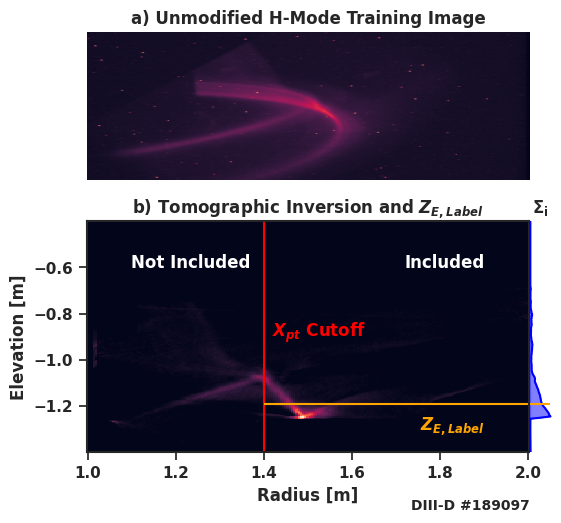

In [97]:
idx = 150

rx = np.argmin(np.abs(radii[0]-1.4))
sum_outer = np.sum(inverted[idx][:,rx:],axis=1)
indicies = np.arange(0, inverted[idx].shape[0])
weighted_square_sum = np.sum((indicies * sum_outer)**2)
total_square_weight = np.sum(sum_outer**2)
sqrt_sum_sq_avg = np.divide(weighted_square_sum, total_square_weight)**0.5
sqrt_sum_sq_avg = int(sqrt_sum_sq_avg)
z_arr_ssa = elevation[0][sqrt_sum_sq_avg]

# Create figure and GridSpec layout
plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1])

# Top left subplot
ax1 = plt.subplot(gs[0, 0])
ax1.imshow(np.flip(vid[int(frames[idx])], axis=1))
ax1.axis('off')
ax1.set_title('a) Unmodified H-Mode Training Image', fontweight='bold')

# Bottom left subplot
ann_zelabel = r"$Z_{E,Label}$"
ann_xptcutoff = r"$X_{pt}$ Cutoff"

ax2 = plt.subplot(gs[1, 0])
cax = ax2.pcolor(radii[0], elevation[0], inverted[idx])
ax2.vlines(1.4, elevation.min(), elevation.max(), colors='red')
ax2.hlines(z_arr_ssa, 1.4, radii[0].max(), colors='orange')
ax2.set_ylim(elevation.min(), elevation.max())
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Elevation [m]')
ax2.set_title('b) Tomographic Inversion and $Z_{E,Label}$', fontweight='bold')
ax2.annotate(f'DIII-D #{files[file_idx].stem.split("_")[-1]}', xy=(1, -0.25), xycoords='axes fraction', ha='right', fontsize=10)
ax2.annotate(f'Included', xy=(0.9, 0.8), xycoords='axes fraction', ha='right', fontsize=12, color = 'White')
ax2.annotate(f'Not Included', xy=(0.1, 0.8), xycoords='axes fraction', ha='left', fontsize=12, color = 'White')
ax2.annotate(ann_zelabel, xy=(0.9,0.1), xycoords='axes fraction', ha='right', fontsize=12, color = 'orange')
ax2.annotate(ann_xptcutoff, xy=(0.63,0.5), xycoords='axes fraction', ha='right', fontsize=12, color = 'red')

# Right subplot (sideways plot)
title = r'$\mathbf{\Sigma_i}$'
ax3 = plt.subplot(gs[1, 1])
ax3.set_title(title)
ax3.plot(sum_outer, elevation[0], color='blue')
ax3.hlines(z_arr_ssa, sum_outer.min(), sum_outer.max(), colors='orange')
ax3.fill_betweenx(elevation[0], sum_outer, sum_outer.min(), where=sum_outer > sum_outer.min(), color='blue', alpha=0.5)
ax3.set_ylim(elevation.min(), elevation.max())
ax3.axis('off')

# Adjust padding between subplots
plt.subplots_adjust(wspace=0.00, hspace=0.00)
# ax3.set_xlabel('Sum of Pixels')
# ax3.set_ylabel('Radius (m)')
# ax3.set_title('Sum of Pixels for Inversion Label')
# ax3.invert_xaxis()

# plt.tight_layout()
plt.savefig('../output/paper/hmode_label.png', dpi=300, bbox_inches='tight')
plt.show()

Number of files: 26
Extracting sav for shot: 190116


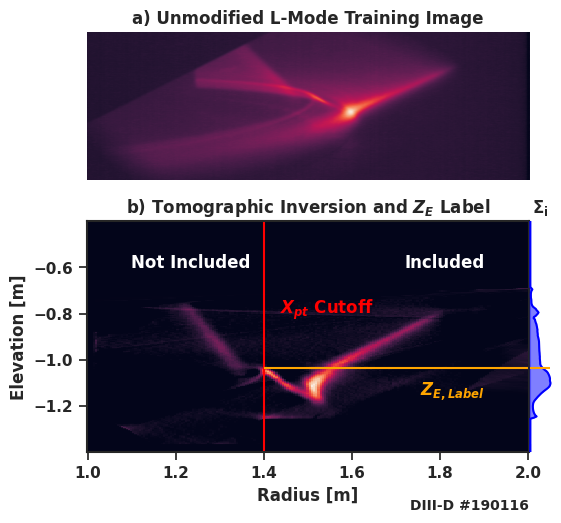

In [98]:
file_idx = 18
tv = GetEmission(Path('../data/raw/all'))
files = tv.list_files()
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])

idx = 100

rx = np.argmin(np.abs(radii[0]-1.4))
sum_outer = np.sum(inverted[idx][:,rx:],axis=1)
indicies = np.arange(0, inverted[idx].shape[0])
weighted_square_sum = np.sum((indicies * sum_outer)**2)
total_square_weight = np.sum(sum_outer**2)
sqrt_sum_sq_avg = np.divide(weighted_square_sum, total_square_weight)**0.5
sqrt_sum_sq_avg = int(sqrt_sum_sq_avg)
z_arr_ssa = elevation[0][sqrt_sum_sq_avg]

# Create figure and GridSpec layout
plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1])

# Top left subplot
ax1 = plt.subplot(gs[0, 0])
ax1.imshow(np.flip(vid[int(frames[idx])], axis=1))
ax1.axis('off')
ax1.set_title('a) Unmodified L-Mode Training Image', fontweight='bold')

# Bottom left subplot
ax2 = plt.subplot(gs[1, 0])
cax = ax2.pcolor(radii[0], elevation[0], inverted[idx])
ax2.vlines(1.4, elevation.min(), elevation.max(), colors='red')
ax2.hlines(z_arr_ssa, 1.4, radii[0].max(), colors='orange')
ax2.set_ylim(elevation.min(), elevation.max())
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Elevation [m]')
ax2.set_title('b) Tomographic Inversion and $Z_E$ Label', fontweight='bold')
ax2.annotate(f'DIII-D #{files[file_idx].stem.split("_")[-1]}', xy=(1, -0.25), xycoords='axes fraction', ha='right', fontsize=10)
ax2.annotate(f'Included', xy=(0.9, 0.8), xycoords='axes fraction', ha='right', fontsize=12, color = 'White')
ax2.annotate(f'Not Included', xy=(0.1, 0.8), xycoords='axes fraction', ha='left', fontsize=12, color = 'White')
ax2.annotate(ann_zelabel, xy=(0.9,0.25), xycoords='axes fraction', ha='right', fontsize=12, color = 'orange')
ax2.annotate(ann_xptcutoff, xy=(0.65,0.6), xycoords='axes fraction', ha='right', fontsize=12, color = 'red')

# Right subplot (sideways plot)
ax3 = plt.subplot(gs[1, 1])
ax3.set_title(title)
ax3.plot(sum_outer, elevation[0], color='blue')
ax3.hlines(z_arr_ssa, sum_outer.min(), sum_outer.max(), colors='orange')
ax3.fill_betweenx(elevation[0], sum_outer, sum_outer.min(), where=sum_outer > sum_outer.min(), color='blue', alpha=0.5)
ax3.set_ylim(elevation.min(), elevation.max())
ax3.axis('off')

# Adjust padding between subplots
plt.subplots_adjust(wspace=0.00, hspace=0.00)
# ax3.set_xlabel('Sum of Pixels')
# ax3.set_ylabel('Radius (m)')
# ax3.set_title('Sum of Pixels for Inversion Label')
# ax3.invert_xaxis()

# plt.tight_layout()
plt.savefig('../output/paper/lmode_label.png', dpi=300, bbox_inches='tight')
plt.show()

## Activation Map

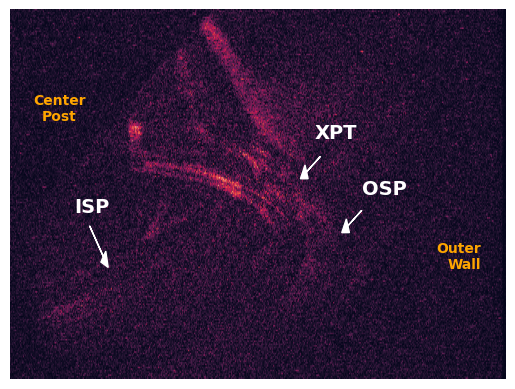

In [99]:
coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt') # outer all 2 is v6, all 5 is ridge
coefficients_2 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_2.append(float(line.strip()))
coef_2_reshape = np.reshape(np.abs(coefficients_2), (vid.shape[1], vid.shape[2])) * 1e7
fig, ax = plt.subplots()
img1 = ax.imshow(np.flip(coef_2_reshape, axis=1))
plt.annotate(f'OSP', xy=(0.8, 0.5), xycoords='axes fraction', ha='right', fontsize=14, color='white')
plt.annotate(f'ISP', xy=(0.2, 0.45), xycoords='axes fraction', ha='right', fontsize=14, color='white')
plt.annotate(f'XPT', xy=(0.7, 0.65), xycoords='axes fraction', ha='right', fontsize=14, color='white')
plt.annotate(f'Center\nPost', xy=(0.1, 0.7), xycoords='axes fraction', ha='center', fontsize=10, color='orange')
plt.annotate(f'Outer\nWall', xy=(0.95, 0.3), xycoords='axes fraction', ha='right', fontsize=10, color='orange')

plt.arrow(115, 140, 20, 20, head_width=10, head_length=10, fc='white', ec='white')
plt.arrow(450, 95, -20, 10, head_width=10, head_length=10, fc='white', ec='white')
plt.arrow(510, 130, -20, 10, head_width=10, head_length=10, fc='white', ec='white')

# fig.colorbar(img1, ax=ax)
ax.set_aspect('auto')
ax.axis('off')
# plt.title('Model 2 Linear Activation Coefficients')
plt.savefig('../output/paper/activation.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

## Video Processing

In [100]:
from plasma_tv.utils.helpers import noisify
from plasma_tv.data.file_utils import GetPkl

In [101]:
tv = GetEmission('../data/raw/all')
files = tv.list_files(False)
all_file_idx = 20
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid_train] = tv.load_all(files[all_file_idx])
tv_pkl = GetPkl('../data/raw/aza_debug')
files_pkl = tv_pkl.list_files(False)
file_idx = 68
# vid, vid_times = tv_pkl.load_raw(files_pkl[file_idx])
vid, vid_times = tv_pkl.load_processed(files_pkl[file_idx])

def match_image_to_histogram(image, target_cdf, bin_edges):
    src_hist, _ = np.histogram(image.ravel(), bins=bin_edges, density=False)
    src_cdf = np.cumsum(src_hist)
    src_cdf_normalized = src_cdf / src_cdf[-1]
    interp_values = np.interp(src_cdf_normalized, target_cdf, bin_edges[:-1])
    matched_image = np.interp(image.ravel(), bin_edges[:-1], interp_values)
    return matched_image.reshape(image.shape)

def match_images_to_histogram(image_array, target_cdf, bin_edges):
    M = image_array.shape[0]
    matched_images = np.empty_like(image_array)
    for i in range(M):
        matched_images[i] = match_image_to_histogram(image_array[i], target_cdf, bin_edges)
    return matched_images * 255

images_N = vid.astype(np.float32)[45:-90] / 255.0
vid_noisy = noisify(vid_train)
images_M = vid_noisy.astype(np.float32) / 255.0

target_cdf = np.load('../data/processed/histogram/target_cdf.npy')
bin_edges = np.load('../data/processed/histogram/bin_edges.npy')
matched_images = match_images_to_histogram(images_M, target_cdf, bin_edges)

Number of files: 26
Extracting sav for shot: 199171


Resizing...
Number of files: 78


In [102]:
plt.rcParams['font.weight'] = 'bold'

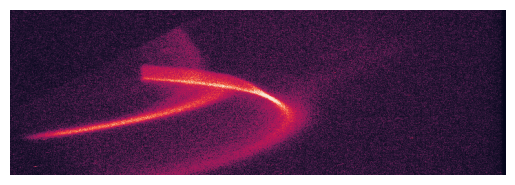

In [103]:
plt.imshow(np.flip(images_N[90],axis=1))
# plt.title('a) Real Time TangTV', fontweight='bold')
plt.axis('off')
plt.savefig('../output/paper/process_rt.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

plt.imshow(np.flip(images_M[90],axis=1))
# plt.title('b) Unmodified Training', fontweight='bold')
plt.axis('off')
plt.savefig('../output/paper/process_base.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.imshow(np.flip(matched_images[90],axis=1))
# plt.title('c) Hist-Matched + Noisy Training', fontweight='bold')
plt.axis('off')
plt.savefig('../output/paper/process_hist.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

plt.imshow(np.flip(np.flip(inverted[90], axis=1),axis=(1,0)))
plt.axis('off')
plt.savefig('../output/paper/process_inv.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

mean = np.mean(matched_images[90], axis=(0,1))
std = np.std(matched_images[90], axis=(0,1))
plt.imshow(np.flip((matched_images[90] - mean) / std,axis=1))
plt.axis('off')
plt.savefig('../output/paper/process_norm.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

## Simulations

In [104]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
from plasma_tv.data.file_utils import GetEmission, GetPkl
from plasma_tv.utils.helpers import *

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

In [105]:
def apply_savitzky_golay_filter(signal, window_length, polyorder):
    # Check if the window length is odd, if not, increment it by 1
    if window_length % 2 == 0:
        window_length += 1
    filtered_signal = savgol_filter(signal, window_length, polyorder)
    return filtered_signal

In [106]:
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files()
file_idx = 7
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')
vid, vid_times = tv.load_processed(files[file_idx])

Number of files: 23
Shot 200977


In [107]:
cbc_colors = {'red':'#dc143c',
           'blue':'#4269e1',
           'olive':'#bfbf00',
    "bk": "#000000",
    "or": "#E69F00",
    "skb": "#56B4E9",
    "gn": "#009E73",
    "yl": "#F0E442",
    "bl": "#0072B2",
    "vn": "#D55E00",
    "rd": "#CC79A7",
    "gn2": "#4daf4a",
    "pk": "#f781bf",
    "bn": "#a65628",
    "gy": "#999999",
}

In [108]:
vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))

In [109]:
h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:] / 1000
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()] / 1000
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()] / 1000
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    lftdz = file[shot]['lftdz'][:]
    lfsdz = file[shot]['lfsdz'][:]
    prad_divl = file[shot]['dgsraddivl'][:]

<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


In [110]:
coefficients_file = Path('../models/092324_tangtv_v2.txt')
coefficients_0 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_0.append(float(line.strip()))

coefficients_file = Path('../models/092624_tangtv_v5.txt')
coefficients_1 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_1.append(float(line.strip()))

coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt') # outer all 2 is v6, all 5 is ridge
coefficients_2 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_2.append(float(line.strip()))

In [111]:
prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614

In [112]:
t_start = 2.000
t_end = t_ip_flat_sql + ip_flat_duration_sql

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
_, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
_, crop_lftdz = crop_time(h5_times, lftdz, t_start, t_end)
_, crop_lfsdz = crop_time(h5_times, lfsdz, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]
interp_lfsdz = interp1d(crop_h5_times, crop_lfsdz, kind=interp_kind, fill_value='extrapolate')(t_grid)

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]
Dz_lfsdz = 1 - interp_lfsdz[0]

xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2 + xptmod) / (interp_ZXPT - interp_ZStrike))[0]

In [113]:
mdl_200977 = np.concatenate([t_grid, Dz_0/2, Dz_1, Dz_2, interp_prad_divl/1e6])
np.save('../output/paper/mdl_200977.npy', mdl_200977)

/tmp/ipykernel_2249103/2082366019.py:3: RuntimeWarning: invalid value encountered in sqrt
  ln1 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_0/2),50,6), c=cbc_colors['pk'], linestyle='-', label='$DZ_{Base} * 0.5$',linewidth=2)


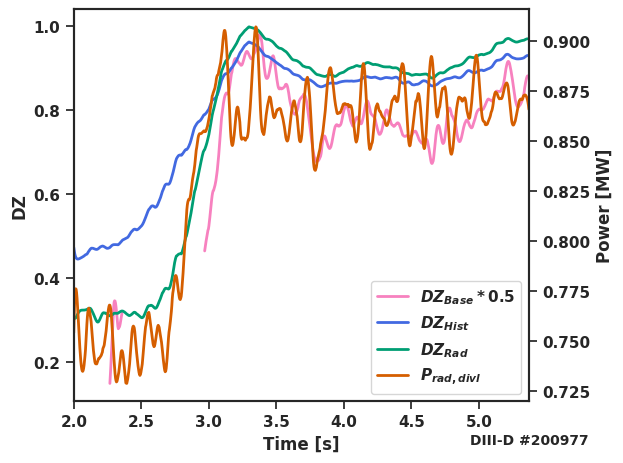

In [114]:
fig, ax1 = plt.subplots()

ln1 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_0/2),50,6), c=cbc_colors['pk'], linestyle='-', label='$DZ_{Base} * 0.5$',linewidth=2)
ln2 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_1),50,6), c=cbc_colors['blue'], linestyle='-', label='$DZ_{Hist}$',linewidth=2)
ln3 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_2),50,6), c=cbc_colors['gn'], linestyle='-', label='$DZ_{Rad}$',linewidth=2)
# plt.plot(t_grid,Dz_lftdz,label='Target')
# plt.plot(t_grid,Dz_lfsdz,label='Signal')
ax1.set_ylabel('DZ')
ax1.set_xlabel('Time [s]')

ax2 = ax1.twinx()
ln4 = ax2.plot(t_grid, apply_savitzky_golay_filter(interp_prad_divl*1e-6, 50, 6), alpha=1,label='$P_{rad,divl}$', color=cbc_colors['vn'],linewidth=2)
ax2.set_ylabel('Power [MW]')

lns = ln1+ln2+ln3 + ln4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc= 'lower right')

# plt.ylim(0.5,1.5)
plt.xlim(t_start,t_end-0.1)
# plt.title(f'L-Mode Characterization on Shot {shotn}', fontweight='bold')
plt.annotate(f'DIII-D #{shot}', xy=(1.13, -0.11), xycoords='axes fraction', ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('../output/paper/200977_mdl.png', dpi=300)
plt.show()

In [116]:
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files()
file_idx = 18
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')
vid, vid_times = tv.load_processed(files[file_idx])

vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))

prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614

t_start = 2.000
t_end = 5.500

h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:] / 1000
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()] / 1000
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()] / 1000
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    lftdz = file[shot]['lftdz'][:]
    lfsdz = file[shot]['lfsdz'][:]
    prad_divl = file[shot]['dgsraddivl'][:]

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
_, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
_, crop_lftdz = crop_time(h5_times, lftdz, t_start, t_end)
_, crop_lfsdz = crop_time(h5_times, lfsdz, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]
interp_lfsdz = interp1d(crop_h5_times, crop_lfsdz, kind=interp_kind, fill_value='extrapolate')(t_grid)

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]
Dz_lfsdz = 1 - interp_lfsdz[0]

xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2 + xptmod) / (interp_ZXPT - interp_ZStrike))[0]

Number of files: 23
Shot 201081
<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


In [117]:
mdl_201081 = np.concatenate([t_grid, Dz_0/2, Dz_1, Dz_2, interp_prad_divl/1e6])
np.save('../output/paper/mdl_201081.npy', mdl_201081)

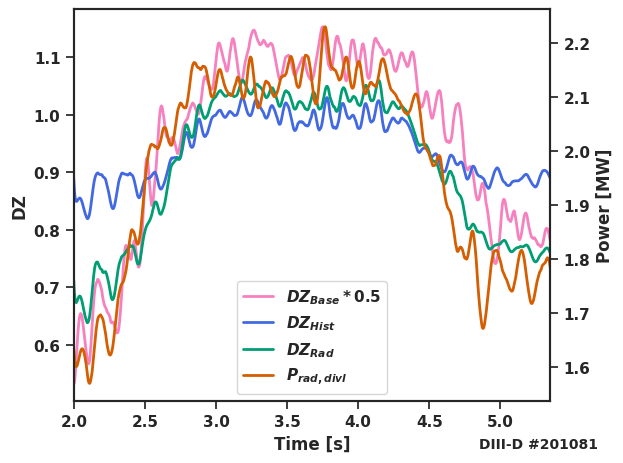

In [118]:
fig, ax1 = plt.subplots()

ln1 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_0/2),50,6), c=cbc_colors['pk'], linestyle='-', label='$DZ_{Base} * 0.5$',linewidth=2)
ln2 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_1),50,6), c=cbc_colors['blue'], linestyle='-', label='$DZ_{Hist}$',linewidth=2)
ln3 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_2),50,6), c=cbc_colors['gn'], linestyle='-', label='$DZ_{Rad}$',linewidth=2)
# plt.plot(t_grid,Dz_lftdz,label='Target')
# plt.plot(t_grid,Dz_lfsdz,label='Signal')
ax1.set_ylabel('DZ')
ax1.set_xlabel('Time [s]')

ax2 = ax1.twinx()
ln4 = ax2.plot(t_grid, apply_savitzky_golay_filter(interp_prad_divl*1e-6, 50, 6), alpha=1,label='$P_{rad,divl}$', color=cbc_colors['vn'],linewidth=2)
ax2.set_ylabel('Power [MW]')

lns = ln1+ln2+ln3 + ln4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower center')

# plt.ylim(0.5,1.5)
plt.xlim(t_start,t_end-.15)

# plt.title(f'H-Mode Characterization on Shot {shotn}', fontweight='bold')
plt.annotate(f'DIII-D #{shot}', xy=(1.1, -0.12), xycoords='axes fraction', ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('../output/paper/201081_mdl.png', dpi=300)
plt.show()

In [119]:
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetEmission('../data/raw/all')
files = tv.list_files()
file_idx = 19
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])
shotn = files[file_idx].stem.split('_')[-1]

vid_noisy = noisify(vid)
images_M = vid_noisy.astype(np.float32) / 255.0

target_cdf = np.load('../data/processed/histogram/target_cdf.npy')
bin_edges = np.load('../data/processed/histogram/bin_edges.npy')
vid = match_images_to_histogram(images_M, target_cdf, bin_edges)

vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))

prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614

t_start = 2000
t_end = 4600

h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:]
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()]
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()]
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    prad_divl = file[shot]['dgsraddivl'][:]

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
_, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
_, crop_lftdz = crop_time(h5_times, lftdz, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]

xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2 + xptmod) / (interp_ZXPT - interp_ZStrike))[0]

Number of files: 26
Extracting sav for shot: 199166
Resizing...
<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


In [120]:
mdl_199166 = np.concatenate([t_grid, Dz_0/2, Dz_1, Dz_2, interp_prad_divl/1e6])
np.save('../output/paper/mdl_199166.npy', mdl_199166)

/tmp/ipykernel_2249103/1748790617.py:3: RuntimeWarning: invalid value encountered in sqrt
  ln1 = ax1.plot(t_grid/1000, apply_savitzky_golay_filter(np.sqrt(Dz_0/2),50,6), c=cbc_colors['pk'], linestyle='-', label='$DZ_{Base} * 0.5$',linewidth=2)


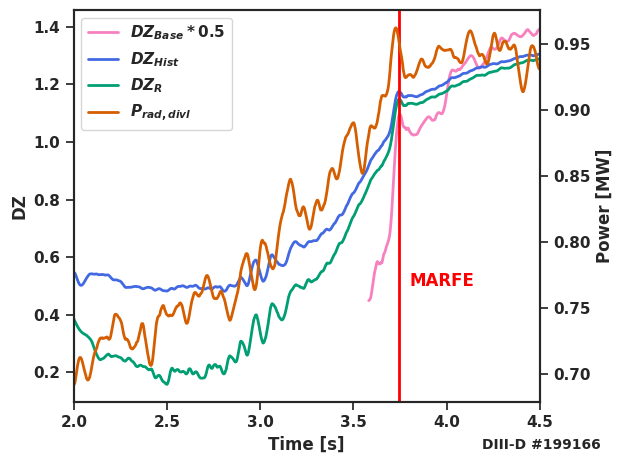

In [121]:
fig, ax1 = plt.subplots()

ln1 = ax1.plot(t_grid/1000, apply_savitzky_golay_filter(np.sqrt(Dz_0/2),50,6), c=cbc_colors['pk'], linestyle='-', label='$DZ_{Base} * 0.5$',linewidth=2)
ln2 = ax1.plot(t_grid/1000, apply_savitzky_golay_filter(np.sqrt(Dz_1),50,6), c=cbc_colors['blue'], linestyle='-', label='$DZ_{Hist}$',linewidth=2)
ln3 = ax1.plot(t_grid/1000, apply_savitzky_golay_filter(np.sqrt(Dz_2),50,6), c=cbc_colors['gn'], linestyle='-', label='$DZ_{R}$',linewidth=2)
# plt.plot(t_grid,Dz_lftdz,label='Target')
# plt.plot(t_grid,Dz_lfsdz,label='Signal')
ax1.axvline(3.745, color='red', label='IP Flat', linewidth=2)
# plt.plot(t_grid,Dz_lftdz,label='Target')
# plt.plot(t_grid,Dz_lfsdz,label='Signal')
ax1.set_ylabel('DZ')
ax1.set_xlabel('Time [s]')
ax1.annotate('MARFE', xy=(3.745, 0.5), xytext=(3.8, 0.5), color='red', fontsize=12)

ax2 = ax1.twinx()
ln4 = ax2.plot(t_grid/1000, apply_savitzky_golay_filter(interp_prad_divl*1e-6, 50, 6), alpha=1,label='$P_{rad,divl}$', color=cbc_colors['vn'],linewidth=2)
ax2.set_ylabel('Power [MW]')

lns = ln1+ln2+ln3 + ln4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

# plt.ylim(0.5,1.5)
plt.xlim(t_start / 1000,t_end / 1000 -.1)

# plt.title(f'MARFE characterization on Shot {shotn}')
plt.annotate(f'DIII-D #{shot}', xy=(1.13, -0.12), xycoords='axes fraction', ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('../output/paper/199166_mdl.png', dpi=300)
plt.show()

In [43]:
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files()
file_idx = 22
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')
vid, vid_times = tv.load_processed(files[file_idx])

vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))

prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614

t_start = 2.000
t_end = 5.500

h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:] / 1000
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()] / 1000
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()] / 1000
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    lftdz = file[shot]['lftdz'][:]
    lfsdz = file[shot]['lfsdz'][:]
    prad_divl = file[shot]['dgsraddivl'][:]

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
_, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
_, crop_lftdz = crop_time(h5_times, lftdz, t_start, t_end)
_, crop_lfsdz = crop_time(h5_times, lfsdz, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]
interp_lfsdz = interp1d(crop_h5_times, crop_lfsdz, kind=interp_kind, fill_value='extrapolate')(t_grid)

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]
Dz_lfsdz = 1 - interp_lfsdz[0]

xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2 + xptmod) / (interp_ZXPT - interp_ZStrike))[0]

Number of files: 23
Shot 201085
<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


In [44]:
mdl_201085 = np.concatenate([t_grid, Dz_0/2, Dz_1, Dz_2, interp_prad_divl/1e6])
np.save('../output/paper/mdl_201085.npy', mdl_201085)

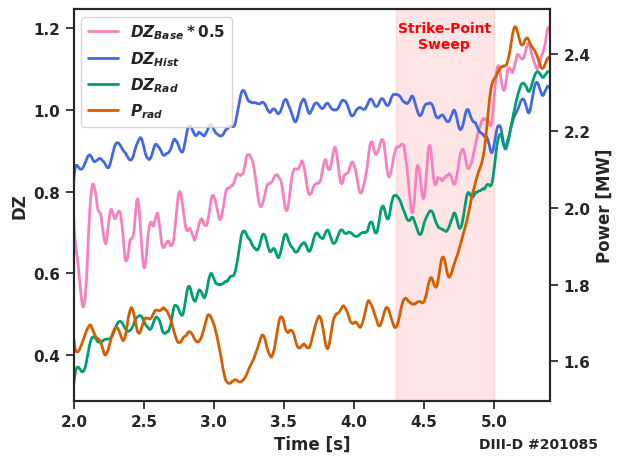

In [ ]:
fig, ax1 = plt.subplots()

ln1 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_0/2),50,6), c=cbc_colors['pk'], linestyle='-', label='$DZ_{Base} * 0.5$',linewidth=2)
ln2 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_1),50,6), c=cbc_colors['blue'], linestyle='-', label='$DZ_{Hist}$',linewidth=2)
ln3 = ax1.plot(t_grid, apply_savitzky_golay_filter(np.sqrt(Dz_2),50,6), c=cbc_colors['gn'], linestyle='-', label='$DZ_{Rad}$',linewidth=2)
ax1.axvspan(4.3, 5, color='red', alpha=0.1)
# plt.plot(t_grid,Dz_lftdz,label='Target')
# plt.plot(t_grid,Dz_lfsdz,label='Signal')
ax1.set_ylabel('DZ')
ax1.set_xlabel('Time [s]')

ax2 = ax1.twinx()
ln4 = ax2.plot(t_grid, apply_savitzky_golay_filter(interp_prad_divl*1e-6, 50, 6), alpha=1,label='$P_{rad,divl}$', color=cbc_colors['vn'],linewidth=2)
ax2.set_ylabel('Power [MW]')

lns = ln1+ln2+ln3 + ln4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

# plt.ylim(0.5,1.5)
plt.xlim(t_start,t_end-.1)

# plt.title(f'H-Mode Characterization on Shot {shotn}', fontweight='bold')
plt.annotate(f'Strike-Point\nSweep', xy=(0.778,0.9), xycoords='axes fraction', ha='center', fontsize=10, color = 'red')
plt.annotate(f'DIII-D #{shot}', xy=(1.1, -0.12), xycoords='axes fraction', ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('../output/paper/201085_mdl.png', dpi=300)
plt.show()

In [46]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
irtv_path = Path('../data/external/toksearch/irtv_12_03_2024.pkl')
ir_shot = 13 # 9 for 201081, 12 for 201084, 13 for 201085
irtv_shots = range(201072,201086)
irtv = pickle.load(open(irtv_path, 'rb'))
irtv_data = irtv[ir_shot]
shot, x_ir, t_ir, pos_ir, units_ir = irtv_data
x_ir /= 100
pos_ir /= 100
t_ir /= 1000

int_x_ir = np.sum(x_ir, axis=1) / x_ir.shape[1]
lowpass = gaussian_filter1d(int_x_ir, 100)

t_ir_edges = np.concatenate(([t_ir[0] - (t_ir[1] - t_ir[0]) / 2], 
                                  (t_ir[:-1] + t_ir[1:]) / 2, 
                                  [t_ir[-1] + (t_ir[-1] - t_ir[-2]) / 2]))

pos_ir_edges = np.concatenate(([pos_ir[0] - (pos_ir[1] - pos_ir[0]) / 2], 
                               (pos_ir[:-1] + pos_ir[1:]) / 2, 
                               [pos_ir[-1] + (pos_ir[-1] - pos_ir[-2]) / 2]))
def apply_savitzky_golay_filter(signal, window_length, polyorder):
    # Check if the window length is odd, if not, increment it by 1
    if window_length % 2 == 0:
        window_length += 1
    filtered_signal = savgol_filter(signal, window_length, polyorder)
    return filtered_signal
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files()
file_idx = 22 # 4: lmode scan rxpt, 18: change zxpt, 21,22: change rxpt
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')
vid, vid_times = tv.load_processed(files[file_idx])
cbc_colors = {'red':'#dc143c',
           'blue':'#4269e1',
           'olive':'#bfbf00',
    "bk": "#000000",
    "or": "#E69F00",
    "skb": "#56B4E9",
    "gn": "#009E73",
    "yl": "#F0E442",
    "bl": "#0072B2",
    "vn": "#D55E00",
    "rd": "#CC79A7",
    "gn2": "#4daf4a",
    "pk": "#f781bf",
    "bn": "#a65628",
    "gy": "#999999",
}
vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))
h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:] / 1000
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()] / 1000
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()] / 1000
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    lftdz = file[shot]['lftdz'][:]
    lfsdz = file[shot]['lfsdz'][:]
    prad_divl = file[shot]['dgsraddivl'][:]
coefficients_file = Path('../models/092324_tangtv_v2.txt')
coefficients_0 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_0.append(float(line.strip()))

coefficients_file = Path('../models/092624_tangtv_v5.txt')
coefficients_1 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_1.append(float(line.strip()))

coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt') # outer all 2 is v6, all 5 is ridge
coefficients_2 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_2.append(float(line.strip()))
        
coefficients_file = Path('../models/weighted_outer_all6_coefficients.txt')
coefficients_3 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_3.append(float(line.strip()))
prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614
prediction_3 = np.dot(vid_process_2*255, coefficients_3[:-1]) - 1.0171065 # replace with num

t_start = 3.5
t_end = 5.5

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
_, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prediction_3 = crop_time(vid_times, prediction_3, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
_, crop_lftdz = crop_time(h5_times, lftdz, t_start, t_end)
_, crop_lfsdz = crop_time(h5_times, lfsdz, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_3 = interp1d(crop_vid_times, crop_prediction_3, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]
interp_lfsdz = interp1d(crop_h5_times, crop_lfsdz, kind=interp_kind, fill_value='extrapolate')(t_grid)

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]
Dz_lfsdz = 1 - interp_lfsdz[0]
xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
Dz_3 = 1 - ((interp_ZXPT - interp_prediction_2 + xptmod) / (interp_ZXPT - interp_ZStrike))[0]

Number of files: 23
Shot 201085
<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


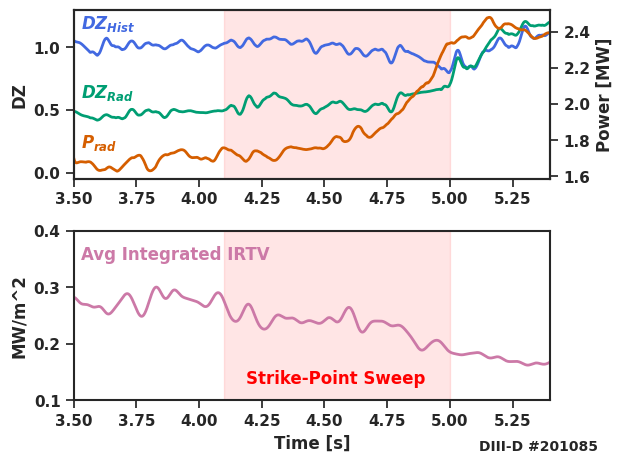

In [ ]:
fig, ax1 = plt.subplots(2,1)

# ln1 = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_0/2,50,6), c=cbc_colors['pk'],alpha=0.7, linestyle='-', label='MDL-Base (/2)',linewidth=2)
ln2 = ax1[0].plot(t_grid, apply_savitzky_golay_filter(Dz_1,50,6), c=cbc_colors['blue'], linestyle='-', label='MDL-Hist',linewidth=2)
# ln3 = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_2,50,6), c=cbc_colors['gn'], linestyle='-', label='MDL-Norm',linewidth=2)
lnb = ax1[0].plot(t_grid, apply_savitzky_golay_filter(Dz_3,50,6), c=cbc_colors['gn'], linestyle='-', label='MDL-R',linewidth=2)
ax1[0].set_ylabel('DZ')
ax1[0].axvspan(4.1, 5, color='red', alpha=0.1)
ax1[0].set_ylim(-0.05,1.3)
ax1[0].annotate('$DZ_{Hist}$', xy=(4.5, 1.1), xytext=(3.53, 1.15),c=cbc_colors['blue'])
ax1[0].annotate('$DZ_{Rad}$', xy=(4.5, 1.2), xytext=(3.53, 0.6),c=cbc_colors['gn'])
ax1[0].annotate('$P_{rad,divl}$', xy=(4.5, 1.3), xytext=(3.53, 0.2),c=cbc_colors['vn'])
# for i in spikes_times:
#     plt.axvline(i, color='r')

ax1[0].set_xlim(t_start,t_end-.1)
# plt.vlines(spikes_times, 0, 1.3, color='r', linestyle='--')
ax2 = ax1[0].twinx()
lnp = ax2.plot(t_grid, apply_savitzky_golay_filter(interp_prad_divl*1e-6, 50, 6), alpha=1,label='$Prad_{divl}$', color=cbc_colors['vn'],linewidth=2)
ax2.set_ylabel('Power [MW]')

lns = ln2 + lnb + lnp
labs = [l.get_label() for l in lns]
# ax2.legend(lns, labs, loc=0)

ax1[1].plot(t_ir, lowpass, c=cbc_colors['rd'], linestyle='-', label='Avg IRTV',linewidth=2)
ax1[1].axvspan(4.1, 5, color='red', alpha=0.1)
ax1[1].set_ylim(0.1, 0.4)
ax1[1].set_ylabel('MW/m^2')
ax1[1].set_xlim(t_start,t_end-.1)
ax1[1].set_xlabel('Time [s]')
# ax1[1].legend()
ax1[1].annotate('Avg Integrated IRTV', xy=(4.5, 0.35), xytext=(3.53, 0.35),c=cbc_colors['rd'])
ax1[1].annotate(f'DIII-D #{shot}', xy=(1.1, -0.3), xycoords='axes fraction', ha='right', fontsize=10)
ax1[1].annotate(f'Strike-Point Sweep', xy=(0.55,0.1), xycoords='axes fraction', ha='center', fontsize=12, color = 'red')
plt.tight_layout()
plt.savefig('../output/paper/201085_R.png', dpi=300)
plt.show()

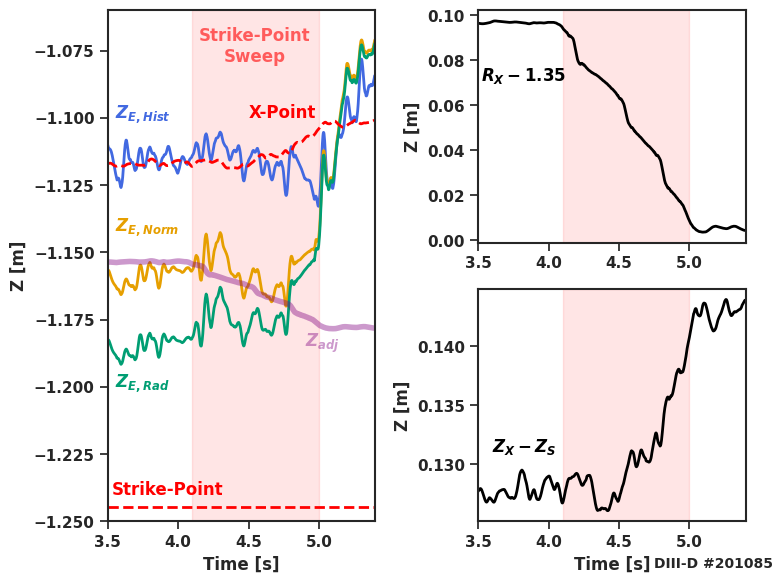

In [48]:
plt.figure(figsize=(8,6))

# --- Left subplot (occupies first column: positions 1 and 3 in a 2x2 grid) ---
plt.subplot(2, 2, (1, 3))
plt.plot(t_grid, apply_savitzky_golay_filter(interp_prediction_1[0],50,6), 
         label='$Z_E$ HIST', linewidth=2, c=cbc_colors['blue'])
plt.plot(t_grid, apply_savitzky_golay_filter(interp_prediction_2[0],50,6), 
         label='$Z_E$ NORM', linewidth=2, c=cbc_colors['or'])
plt.plot(t_grid, apply_savitzky_golay_filter(interp_prediction_2[0] - xptmod,50,6), 
         label='$Z_E$ R', linewidth=2, c=cbc_colors['gn'])
plt.plot(t_grid, apply_savitzky_golay_filter(interp_ZXPT[0],50,6), 
         linestyle='--', linewidth=2,color='red')
plt.plot(t_grid, apply_savitzky_golay_filter(-1.1795 + xptmod, 50,6), 
         linewidth=4, alpha=0.4, label='1.18 - XPTMOD', color='purple')
plt.axvspan(4.1, 5, color='red', alpha=0.1)
plt.axhline(-1.24477, color='red', linestyle='--', linewidth=2)
plt.ylim(-1.25, -1.06)
plt.xlim(3.5, 5.4)
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')

zehist = r'$Z_{E,Hist}$'
zenorm = r'$Z_{E,Norm}$'
zerad = r'$Z_{E,Rad}$'
zadj = r'$Z_{adj}$'
plt.annotate(zehist, xy=(4.6, -1.1), xytext=(3.55, -1.1), color=cbc_colors['blue'])
plt.annotate(zenorm, xy=(4.6, -1.15), xytext=(3.55, -1.142), color=cbc_colors['or'])
plt.annotate(zerad, xy=(4.6, -1.2), xytext=(3.55, -1.2), color=cbc_colors['gn'])
plt.annotate('X-Point', xy=(4.5, -1.25), xytext=(4.5, -1.1), color='red')
plt.annotate('Strike-Point', xy=(4.5, -1.24), xytext=(3.53, -1.24), color='red')
plt.annotate('Strike-Point\nSweep', xy=(0.55,0.9), xycoords='axes fraction', ha='center', fontsize=12, color = 'red', alpha=0.6)
plt.annotate(zadj, xy=(4.5, -1.18), xytext=(4.9, -1.185), color='purple', alpha=0.4)
# plt.legend()

# --- Top-right subplot ---
plt.subplot(2, 2, 2)
plt.plot(t_grid, apply_savitzky_golay_filter(interp_RXPT[0] - 1.35, 50, 6), 
         label='$R_X - 1.35$', linewidth=2, c='black')
plt.axvspan(4.1, 5, color='red', alpha=0.1)
plt.xlim(3.5, 5.4)
plt.annotate('$R_{X} - 1.35$', xy=(0.01, 0.7), xycoords='axes fraction', c='black')
plt.ylabel('Z [m]')
# plt.legend()

# --- Bottom-right subplot ---
plt.subplot(2, 2, 4)
plt.plot(t_grid, apply_savitzky_golay_filter((interp_ZXPT - interp_ZStrike)[0], 50, 6), 
         label='Z) - ZStrike', linewidth=2, c='black')
plt.axvspan(4.1, 5, color='red', alpha=0.1)
plt.xlim(3.5, 5.4)
plt.annotate('$Z_{X} - Z_{S}$', xy=(0.05, 0.3), xycoords='axes fraction', c='black')
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
# plt.legend()

plt.annotate(f'DIII-D #{shot}', xy=(1.1, -0.2), xycoords='axes fraction', ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('../output/paper/201085_Z.png', dpi=300)
plt.show()

In [49]:
irtv_path = Path('../data/external/toksearch/irtv_12_03_2024.pkl')
ir_shot = 12 # 9 for 201081, 12 for 201084, 13 for 201085
irtv_shots = range(201072,201086)
irtv = pickle.load(open(irtv_path, 'rb'))
irtv_data = irtv[ir_shot]
shot, x_ir, t_ir, pos_ir, units_ir = irtv_data
x_ir /= 100
pos_ir /= 100
t_ir /= 1000

int_x_ir = np.sum(x_ir, axis=1) / x_ir.shape[1]
lowpass = gaussian_filter1d(int_x_ir, 100)

t_ir_edges = np.concatenate(([t_ir[0] - (t_ir[1] - t_ir[0]) / 2], 
                                  (t_ir[:-1] + t_ir[1:]) / 2, 
                                  [t_ir[-1] + (t_ir[-1] - t_ir[-2]) / 2]))

pos_ir_edges = np.concatenate(([pos_ir[0] - (pos_ir[1] - pos_ir[0]) / 2], 
                               (pos_ir[:-1] + pos_ir[1:]) / 2, 
                               [pos_ir[-1] + (pos_ir[-1] - pos_ir[-2]) / 2]))
def apply_savitzky_golay_filter(signal, window_length, polyorder):
    # Check if the window length is odd, if not, increment it by 1
    if window_length % 2 == 0:
        window_length += 1
    filtered_signal = savgol_filter(signal, window_length, polyorder)
    return filtered_signal
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files()
file_idx = 21 # 4: lmode scan rxpt, 18: change zxpt, 21,22: change rxpt
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')
vid, vid_times = tv.load_processed(files[file_idx])
cbc_colors = {'red':'#dc143c',
           'blue':'#4269e1',
           'olive':'#bfbf00',
    "bk": "#000000",
    "or": "#E69F00",
    "skb": "#56B4E9",
    "gn": "#009E73",
    "yl": "#F0E442",
    "bl": "#0072B2",
    "vn": "#D55E00",
    "rd": "#CC79A7",
    "gn2": "#4daf4a",
    "pk": "#f781bf",
    "bn": "#a65628",
    "gy": "#999999",
}
vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))
h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:] / 1000
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()] / 1000
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()] / 1000
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    lftdz = file[shot]['lftdz'][:]
    lfsdz = file[shot]['lfsdz'][:]
    prad_divl = file[shot]['dgsraddivl'][:]
coefficients_file = Path('../models/092324_tangtv_v2.txt')
coefficients_0 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_0.append(float(line.strip()))

coefficients_file = Path('../models/092624_tangtv_v5.txt')
coefficients_1 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_1.append(float(line.strip()))

coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt') # outer all 2 is v6, all 5 is ridge
coefficients_2 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_2.append(float(line.strip()))
        
coefficients_file = Path('../models/weighted_outer_all6_coefficients.txt')
coefficients_3 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_3.append(float(line.strip()))
prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614
prediction_3 = np.dot(vid_process_2*255, coefficients_3[:-1]) - 1.0171065 # replace with num

t_start = 2
t_end = 5.5

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
_, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prediction_3 = crop_time(vid_times, prediction_3, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
_, crop_lftdz = crop_time(h5_times, lftdz, t_start, t_end)
_, crop_lfsdz = crop_time(h5_times, lfsdz, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_3 = interp1d(crop_vid_times, crop_prediction_3, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]
interp_lfsdz = interp1d(crop_h5_times, crop_lfsdz, kind=interp_kind, fill_value='extrapolate')(t_grid)

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]
Dz_lfsdz = 1 - interp_lfsdz[0]
xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
Dz_3 = 1 - ((interp_ZXPT - interp_prediction_2 + xptmod) / (interp_ZXPT - interp_ZStrike))[0]

Number of files: 23
Shot 201084
<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


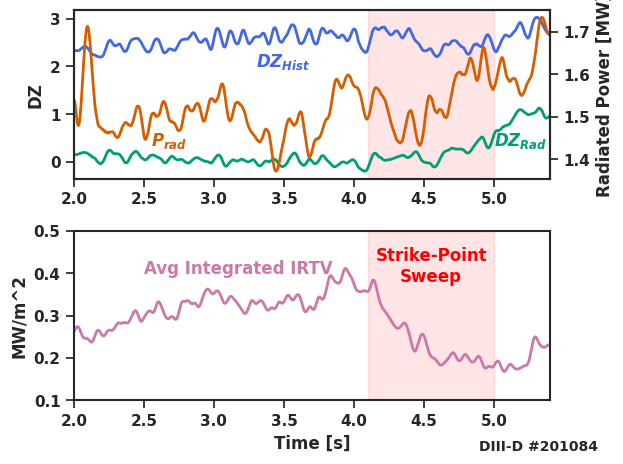

In [ ]:
fig, ax1 = plt.subplots(2,1)

# ln1 = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_0/2,50,6), c=cbc_colors['pk'],alpha=0.7, linestyle='-', label='MDL-Base (/2)',linewidth=2)
ln2 = ax1[0].plot(t_grid, apply_savitzky_golay_filter(Dz_1,50,6), c=cbc_colors['blue'], linestyle='-', label='MDL-Hist',linewidth=2)
# ln3 = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_2,50,6), c=cbc_colors['gn'], linestyle='-', label='MDL-Norm',linewidth=2)
lnb = ax1[0].plot(t_grid, apply_savitzky_golay_filter(Dz_3,50,6), c=cbc_colors['gn'], linestyle='-', label='MDL-R',linewidth=2)
ax1[0].set_ylabel('DZ')
ax1[0].axvspan(4.1, 5, color='red', alpha=0.1)
ax1[0].set_xlim(2, 5.5)
ax1[0].annotate('$DZ_{Hist}$', xy=(4.5, 1.1), xytext=(3.3, 2),c=cbc_colors['blue'])
ax1[0].annotate('$DZ_{Rad}$', xy=(4.5, 1.2), xytext=(5, 0.34),c=cbc_colors['gn'])
ax1[0].annotate('$P_{rad,divl}$', xy=(4.5, 1.3), xytext=(2.55, 0.35),c=cbc_colors['vn'])

# for i in spikes_times:
#     plt.axvline(i, color='r')

ax1[0].set_xlim(t_start,t_end-0.1)
# plt.vlines(spikes_times, 0, 1.3, color='r', linestyle='--')
ax2 = ax1[0].twinx()
lnp = ax2.plot(t_grid, apply_savitzky_golay_filter(interp_prad_divl*1e-6, 50, 6), alpha=1,label='$Prad_{divl}$', color=cbc_colors['vn'],linewidth=2)
ax2.set_ylabel('Radiated Power [MW]')

lns = ln2 + lnb + lnp
labs = [l.get_label() for l in lns]
# ax2.legend(lns, labs, loc=0)

ax1[1].plot(t_ir, lowpass, c=cbc_colors['rd'], linestyle='-', label='Avg IRTV',linewidth=2)
ax1[1].axvspan(4.1, 5, color='red', alpha=0.1)
ax1[1].set_ylim(0.1, 0.5)
ax1[1].set_ylabel('MW/m^2')
ax1[1].annotate('Avg Integrated IRTV', xy=(2, 0.4), xytext=(2.5, 0.4),c=cbc_colors['rd'])
ax1[1].annotate('Strike-Point\nSweep', xy=(0.75,0.7), xycoords='axes fraction', ha='center', fontsize=12, color = 'red')
# ax1[1].legend()
ax1[1].annotate(f'DIII-D #{shot}', xy=(1.1, -0.3), xycoords='axes fraction', ha='right', fontsize=10)
ax1[1].set_xlim(t_start,t_end-0.1)
ax1[1].set_xlabel('Time [s]')
plt.tight_layout()
plt.savefig('../output/paper/201084_R.png', dpi=300)
plt.show()

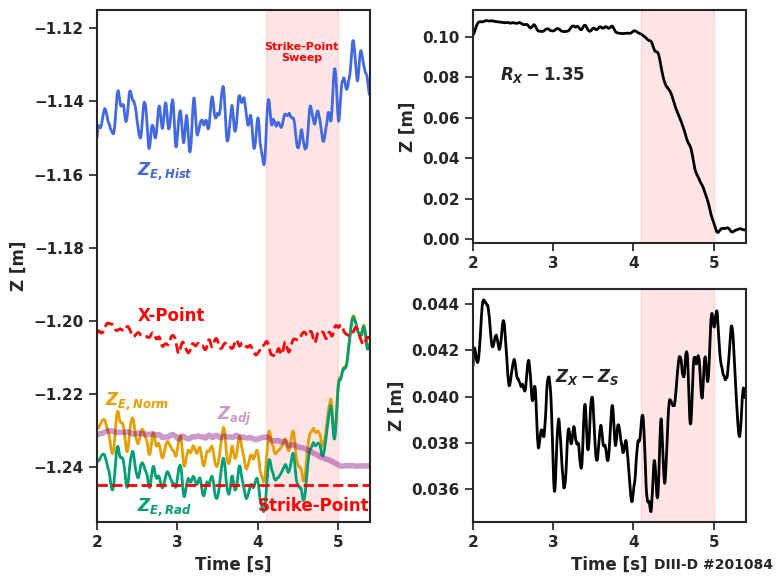

In [51]:
plt.figure(figsize=(8,6))

# --- Left subplot (occupies first column: positions 1 and 3 in a 2x2 grid) ---
plt.subplot(2, 2, (1, 3))
plt.plot(t_grid, apply_savitzky_golay_filter(interp_prediction_1[0],50,6), linewidth=2, c=cbc_colors['blue'])
plt.plot(t_grid, apply_savitzky_golay_filter(interp_prediction_2[0],50,6), linewidth=2, c=cbc_colors['or'])
plt.plot(t_grid, apply_savitzky_golay_filter(interp_prediction_2[0] - xptmod,50,6), 
         label='$Z_E$ R', linewidth=2, c=cbc_colors['gn'])
plt.plot(t_grid, apply_savitzky_golay_filter(interp_ZXPT[0],50,6), 
         linestyle='--', linewidth=2, color='red')
plt.plot(t_grid, apply_savitzky_golay_filter(-1.24 + xptmod, 50,6), 
         linewidth=4, alpha=0.4, label='1.24 - XPTMOD', color='purple')
plt.axvspan(4.1, 5, color='red', alpha=0.1)
plt.axhline(-1.24477, color='r', linestyle='--', linewidth=2, c='red')
plt.ylim(-1.255, -1.115)
plt.xlim(t_start,t_end-.1)
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.annotate(zehist, xy=(4.5, -1.15), xytext=(2.5, -1.16), c=cbc_colors['blue'])
plt.annotate(zenorm, xy=(4.5, -1.2), xytext=(2.1, -1.223), c=cbc_colors['or'])
plt.annotate(zerad, xy=(4.5, -1.24), xytext=(2.5, -1.252), c=cbc_colors['gn'])
plt.annotate(zadj, xy=(4.5, -1.18), xytext=(3.5, -1.227), color='purple', alpha=0.4)
plt.annotate('X-Point', xy=(4.5, -1.2), xytext=(2.5, -1.2), c='red')
plt.annotate('Strike-Point', xy=(4.5, -1.24), xytext=(4.0, -1.252), color='red')
plt.annotate('Strike-Point\nSweep', xy=(0.75,0.9), xycoords='axes fraction', ha='center', fontsize=8, color = 'red')
# plt.legend()

# --- Top-right subplot ---
plt.subplot(2, 2, 2)
plt.plot(t_grid, apply_savitzky_golay_filter(interp_RXPT[0] - 1.35, 50, 6), 
         label='RXPT - 1.35', linewidth=2, c='black')
plt.axvspan(4.1, 5, color='red', alpha=0.1)
plt.xlim(t_start,t_end-.1)
plt.ylabel('Z [m]')
plt.annotate('$R_{X} - 1.35$', xy=(0.1, 0.7), xycoords='axes fraction')
# plt.legend()

# --- Bottom-right subplot ---
plt.subplot(2, 2, 4)
plt.plot(t_grid, apply_savitzky_golay_filter((interp_ZXPT - interp_ZStrike)[0], 50, 6), 
         label='Z_X - ZStrike', linewidth=2, c='black')
plt.axvspan(4.1, 5, color='red', alpha=0.1)
plt.xlim(t_start,t_end-.1)
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.annotate('$Z_{X} - Z_{S}$', xy=(0.3, 0.6), xycoords='axes fraction')
# plt.legend()

plt.annotate(f'DIII-D #{shot}', xy=(1.1, -0.2), xycoords='axes fraction', ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('../output/paper/201084_Z.png', dpi=300)
plt.show()

In [123]:
def apply_savitzky_golay_filter(signal, window_length, polyorder):
    # Check if the window length is odd, if not, increment it by 1
    if window_length % 2 == 0:
        window_length += 1
    filtered_signal = savgol_filter(signal, window_length, polyorder)
    return filtered_signal

cbc_colors = {'red':'#dc143c',
           'blue':'#4269e1',
           'olive':'#bfbf00',
    "bk": "#000000",
    "or": "#E69F00",
    "skb": "#56B4E9",
    "gn": "#009E73",
    "yl": "#F0E442",
    "bl": "#0072B2",
    "vn": "#D55E00",
    "rd": "#CC79A7",
    "gn2": "#4daf4a",
    "pk": "#f781bf",
    "bn": "#a65628",
    "gy": "#999999",
}

In [124]:
value_path = Path('../data/processed/') / 'weight_ml_point'
irtv_path = Path('../data/external/toksearch/irtv_12_03_2024.pkl')
h5_path = Path('../data/external/toksearch/aps_sig.h5')
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files()

Number of files: 23


In [125]:
compare_idx = range(14)

DZ_norm_tot = []
DZ_rad_tot = []
ir_tot = []
prad_tot = []
divir_tot = []

for c_id in compare_idx:

    # irtv
    ir_shot = c_id # 9 for 201081, 12 for 201084, 13 for 201085
    irtv_shots = range(201072,201086)
    irtv = pickle.load(open(irtv_path, 'rb'))
    irtv_data = irtv[ir_shot]
    irshot, x_ir, t_ir, pos_ir, units_ir = irtv_data
    print('IrTV shot', irshot)

    x_ir /= 100
    pos_ir /= 100
    t_ir /= 1000
    
    int_x_ir = np.sum(x_ir, axis=1) / x_ir.shape[1]
    lowpass_ir = gaussian_filter1d(int_x_ir, 100)
    
    # tangtv
    file_idx = c_id + 9 # 18: change zxpt, 21,22: change rxpt
    shotn = files[file_idx].stem.split('_')[-1]
    shot = str(shotn)
    print(f'TangTV Shot', shot)

    vid, vid_times = tv.load_processed(files[file_idx])
    norm_vid = normalize_image(vid)
    norm_vid = np.reshape(norm_vid, (norm_vid.shape[0], -1))

    with h5py.File(h5_path, 'r') as file:
        
        h5_times = file['times'][:] / 1000
        t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()] / 1000
        ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()] / 1000
        ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
        RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
        prad_divl = file[shot]['dgsraddivl'][:]

    coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt') # outer all 2 is v6, all 5 is ridge
    coefficients = []
    with open(coefficients_file, 'r') as f:
        for line in f:
            coefficients.append(float(line.strip()))

    prediction = np.dot(norm_vid*255, coefficients) - 1.098614

    # align data
    t_start = t_ip_flat_sql + 0.5
    t_end = t_ip_flat_sql + ip_flat_duration_sql - 0.5

    t_grid = np.linspace(t_start, t_end, 1000)
    crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
    _, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
    crop_vid_times, crop_prediction = crop_time(vid_times, prediction, t_start, t_end)
    _, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
    crop_t_ir, crop_ir = crop_time(t_ir, lowpass_ir, t_start, t_end)

    interp_kind = 'next'
    interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
    interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
    interp_prediction = interp1d(crop_vid_times, crop_prediction, kind=interp_kind, fill_value='extrapolate')(t_grid)
    interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]
    interp_ir = interp1d(crop_t_ir, crop_ir, kind=interp_kind, fill_value='extrapolate')(t_grid)

    interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
    xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
    DZ_norm = 1 - ((interp_ZXPT - interp_prediction) / (interp_ZXPT - interp_ZStrike))[0]
    DZ_Rad = 1 - ((interp_ZXPT - interp_prediction + xptmod) / (interp_ZXPT - interp_ZStrike))[0]
    int_ir = interp_ir[0]
    div_ir = np.gradient(int_ir)
    
    DZ_norm_tot.append(DZ_norm)
    DZ_rad_tot.append(DZ_Rad)
    prad_tot.append(interp_prad_divl)
    ir_tot.append(int_ir)
    divir_tot.append(div_ir)
    # t_ir_edges = np.concatenate(([t_ir[0] - (t_ir[1] - t_ir[0]) / 2], 
    #                                 (t_ir[:-1] + t_ir[1:]) / 2, 
    #                                 [t_ir[-1] + (t_ir[-1] - t_ir[-2]) / 2]))

    # pos_ir_edges = np.concatenate(([pos_ir[0] - (pos_ir[1] - pos_ir[0]) / 2], 
    #                             (pos_ir[:-1] + pos_ir[1:]) / 2, 
    #                             [pos_ir[-1] + (pos_ir[-1] - pos_ir[-2]) / 2]))

IrTV shot 201072
TangTV Shot 201072
IrTV shot 201073
TangTV Shot 201073
IrTV shot 201074
TangTV Shot 201074
IrTV shot 201075
TangTV Shot 201075
IrTV shot 201076
TangTV Shot 201076
IrTV shot 201077
TangTV Shot 201077
IrTV shot 201078
TangTV Shot 201078
IrTV shot 201079
TangTV Shot 201079
IrTV shot 201080
TangTV Shot 201080
IrTV shot 201081
TangTV Shot 201081
IrTV shot 201082
TangTV Shot 201082
IrTV shot 201083
TangTV Shot 201083
IrTV shot 201084
TangTV Shot 201084
IrTV shot 201085
TangTV Shot 201085


In [126]:
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

shot 201081
slope: [[-3.0263803]]
intercept: [1.5622318]
r^2: 0.8747989588013223


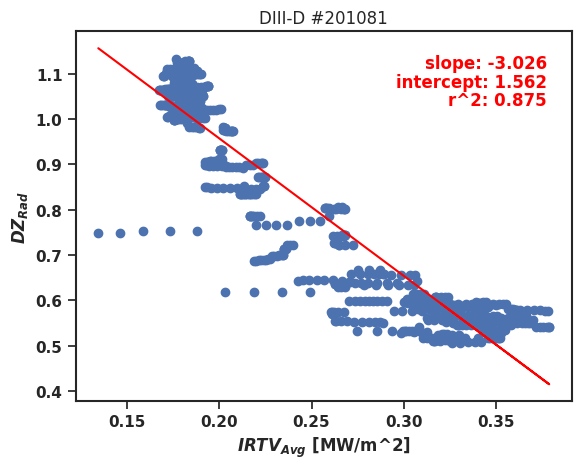

In [127]:
s_id = 9
print('shot', files[s_id + 9].stem.split('_')[-1])
m = ~(np.isnan(ir_tot[s_id]) | np.isnan(DZ_rad_tot[s_id]) | (DZ_rad_tot[s_id] > 2) | (DZ_rad_tot[s_id] < 0.5))
x_m, y_m = ir_tot[s_id][m].reshape(-1, 1), DZ_rad_tot[s_id][m].reshape(-1, 1)                         # remove NaNs
lr = LinearRegression().fit(x_m, y_m)
print('slope:', lr.coef_)
print('intercept:', lr.intercept_)
print('r^2:', lr.score(x_m, y_m))
plt.title(f'DIII-D #{files[s_id + 9].stem.split("_")[-1]}')
plt.annotate(f'slope: {lr.coef_[0][0]:.3f}', xy=(0.95, 0.9), xycoords='axes fraction', c='red', ha = 'right')
plt.annotate(f'intercept: {lr.intercept_[0]:.3f}', xy=(0.95, 0.85), xycoords='axes fraction', c='red', ha = 'right')
plt.annotate(f'r^2: {lr.score(x_m, y_m):.3f}', xy=(0.95, 0.8), xycoords='axes fraction', c='red', ha = 'right')
plt.scatter(x_m, y_m)
plt.plot(x_m, lr.predict(x_m), color='red')
plt.xlabel('$IRTV_{Avg}$ [MW/m^2]')
plt.ylabel('$DZ_{Rad}$')
plt.show()

<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2249103/1906049470.py:30: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sqrt{DZ_{Rad}}$')
/tmp/ipykernel_2249103/1906049470.py:6: RuntimeWarning: invalid value encountered in sqrt
  tototDZ = np.sqrt(np.concatenate([DZ_rad_tot[i] for i in indexinclude]))


slope: [[-2.365654]]
intercept: [1.443447]
r^2: 0.8551239647847222


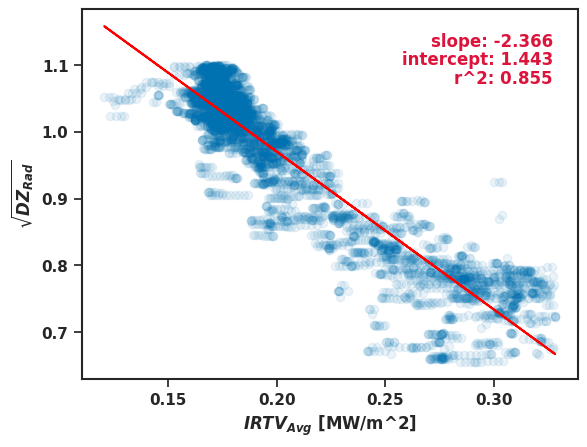

In [140]:
indexinclude = [2,3,4,5,6,8,9,11]
pinj = [4,4,4]

tottotdivir = np.concatenate([divir_tot[i] for i in indexinclude])
tottotir = np.concatenate([ir_tot[i] for i in indexinclude])
tototDZ = np.sqrt(np.concatenate([DZ_rad_tot[i] for i in indexinclude]))

m = ~(np.isnan(tottotir) | np.isnan(tototDZ) | (np.abs(tottotdivir) > 0.003) | (tototDZ > 1.1) | (tototDZ < 0.65)) #| (tototDZ > 1.1) | (tototDZ < 0.65) )#| (tottotir < 0.15) | (tottotir > 0.325))
# Calculate z-scores of the data
z_scores = zscore(tottotir[m])

# Filter out outliers based on z-score
tottotir = tottotir[m]
tototDZ = tototDZ[m]
filtered_indices = np.abs(z_scores) < 2
tottotir = tottotir[filtered_indices]
tototDZ = tototDZ[filtered_indices]

x_m, y_m = tottotir.reshape(-1, 1), tototDZ.reshape(-1, 1)                         # remove NaNs
lr = LinearRegression().fit(x_m, y_m)
print('slope:', lr.coef_)
print('intercept:', lr.intercept_)
print('r^2:', lr.score(x_m, y_m))
plt.annotate(f'slope: {lr.coef_[0][0]:.3f}', xy=(0.95, 0.9), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.annotate(f'intercept: {lr.intercept_[0]:.3f}', xy=(0.95, 0.85), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.annotate(f'r^2: {lr.score(x_m, y_m):.3f}', xy=(0.95, 0.8), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.scatter(x_m, y_m, c=cbc_colors['bl'], alpha = 0.08)
plt.plot(x_m, lr.predict(x_m), color='red')
plt.xlabel('$IRTV_{Avg}$ [MW/m^2]')
plt.ylabel('$\sqrt{DZ_{Rad}}$')
plt.savefig('../output/paper/image (1).png', dpi=300)
plt.show()

shot 201078
slope: [[-3703954.2]]
intercept: [2792913.2]
r^2: 0.8810083570178994


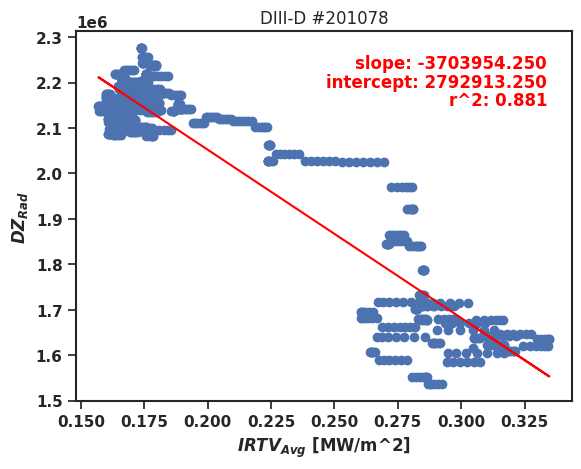

In [130]:
s_id = 6
print('shot', files[s_id + 9].stem.split('_')[-1])
m = ~(np.isnan(ir_tot[s_id]) | np.isnan(prad_tot[s_id]))
x_m, y_m = ir_tot[s_id][m].reshape(-1, 1), prad_tot[s_id][m].reshape(-1, 1)                         # remove NaNs
lr = LinearRegression().fit(x_m, y_m)
print('slope:', lr.coef_)
print('intercept:', lr.intercept_)
print('r^2:', lr.score(x_m, y_m))
plt.title(f'DIII-D #{files[s_id + 9].stem.split("_")[-1]}')
plt.annotate(f'slope: {lr.coef_[0][0]:.3f}', xy=(0.95, 0.9), xycoords='axes fraction', c='red', ha = 'right')
plt.annotate(f'intercept: {lr.intercept_[0]:.3f}', xy=(0.95, 0.85), xycoords='axes fraction', c='red', ha = 'right')
plt.annotate(f'r^2: {lr.score(x_m, y_m):.3f}', xy=(0.95, 0.8), xycoords='axes fraction', c='red', ha = 'right')
plt.scatter(x_m, y_m)
plt.plot(x_m, lr.predict(x_m), color='red')
plt.xlabel('$IRTV_{Avg}$ [MW/m^2]')
plt.ylabel('$DZ_{Rad}$')
plt.show()

In [131]:
for inas in indexinclude:
    print('shot', files[inas + 9].stem.split('_')[-1])

shot 201074
shot 201075
shot 201076
shot 201077
shot 201078
shot 201080
shot 201081
shot 201083


<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2249103/2046758943.py:30: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sqrt{DZ_{Rad}}$')
/tmp/ipykernel_2249103/2046758943.py:6: RuntimeWarning: invalid value encountered in sqrt
  tototDZ = np.concatenate([DZ_rad_tot[i] for i in indexinclude]) ** 0.5


slope: [[0.5618608]]
intercept: [-0.19051274]
r^2: 0.8623349375883509


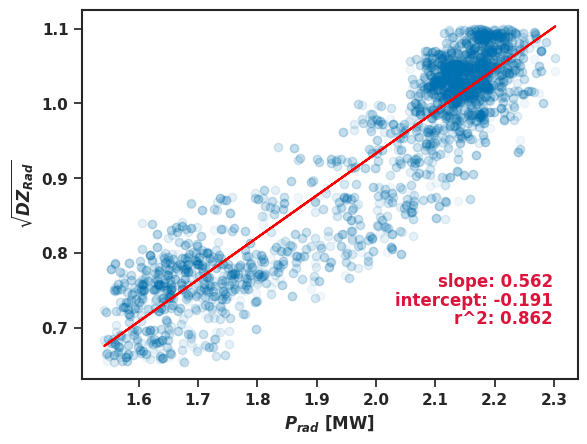

In [141]:
from scipy.stats import zscore

indexinclude = [2,3,4,5,6,8,9,11]
pinj = [4,4,4]
tottotir = np.concatenate([prad_tot[i] for i in indexinclude]) * 1e-6
tototDZ = np.concatenate([DZ_rad_tot[i] for i in indexinclude]) ** 0.5

m = ~(np.isnan(tottotir) | np.isnan(tototDZ) | (tottotir < 0) | (tototDZ < 0.65) | (tototDZ > 1.1))
# Calculate z-scores of the data
z_scores = zscore(tottotir[m])

# Filter out outliers based on z-score
tottotir = tottotir[m]
tototDZ = tototDZ[m]
filtered_indices = np.abs(z_scores) < 2
tottotir = tottotir[filtered_indices]
tototDZ = tototDZ[filtered_indices]

x_m, y_m = tottotir.reshape(-1, 1), tototDZ.reshape(-1, 1)                         # remove NaNs
lr = LinearRegression().fit(x_m, y_m)
print('slope:', lr.coef_)
print('intercept:', lr.intercept_)
print('r^2:', lr.score(x_m, y_m))
plt.annotate(f'slope: {lr.coef_[0][0]:.3f}', xy=(0.95, 0.25), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.annotate(f'intercept: {lr.intercept_[0]:.3f}', xy=(0.95, 0.2), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.annotate(f'r^2: {lr.score(x_m, y_m):.3f}', xy=(0.95, 0.15), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.scatter(x_m, y_m, alpha = 0.05, c=cbc_colors['bl'])
plt.plot(x_m, lr.predict(x_m), color='red')
plt.xlabel('$P_{rad}$ [MW]')
plt.ylabel('$\sqrt{DZ_{Rad}}$')
plt.savefig('../output/paper/image.png', dpi=300)
plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2249103/3237467479.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sqrt{DZ_{Rad}}$')
/tmp/ipykernel_2249103/3237467479.py:4: RuntimeWarning: invalid value encountered in sqrt
  tototDZ = np.concatenate([DZ_norm_tot[i] for i in indexinclude]) ** 0.5


slope: [[0.50393879]]
intercept: [-0.06142393]
r^2: 0.7947101209383916


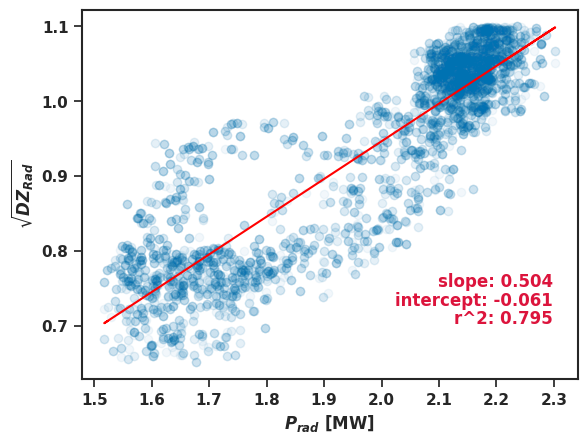

In [142]:
indexinclude = [2,3,4,5,6,8,9,11]
pinj = [4,4,4]
tottotir = np.concatenate([prad_tot[i] for i in indexinclude]) * 1e-6
tototDZ = np.concatenate([DZ_norm_tot[i] for i in indexinclude]) ** 0.5

m = ~(np.isnan(tottotir) | np.isnan(tototDZ) | (tottotir < 0) | (tototDZ < 0.65) | (tototDZ > 1.1))
# Calculate z-scores of the data
z_scores = zscore(tottotir[m])

# Filter out outliers based on z-score
tottotir = tottotir[m]
tototDZ = tototDZ[m]
filtered_indices = np.abs(z_scores) < 2
tottotir = tottotir[filtered_indices]
tototDZ = tototDZ[filtered_indices]

x_m, y_m = tottotir.reshape(-1, 1), tototDZ.reshape(-1, 1)                         # remove NaNs
lr = LinearRegression().fit(x_m, y_m)
print('slope:', lr.coef_)
print('intercept:', lr.intercept_)
print('r^2:', lr.score(x_m, y_m))
plt.annotate(f'slope: {lr.coef_[0][0]:.3f}', xy=(0.95, 0.25), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.annotate(f'intercept: {lr.intercept_[0]:.3f}', xy=(0.95, 0.2), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.annotate(f'r^2: {lr.score(x_m, y_m):.3f}', xy=(0.95, 0.15), xycoords='axes fraction', c=cbc_colors['red'], ha = 'right')
plt.scatter(x_m, y_m, alpha = 0.05, c=cbc_colors['bl'])
plt.plot(x_m, lr.predict(x_m), color='red')
plt.xlabel('$P_{rad}$ [MW]')
plt.ylabel('$\sqrt{DZ_{Rad}}$')
plt.savefig('../output/paper/image (2).png', dpi=300)
plt.show()